In [6]:
import tables
import numpy as np
import json
from datetime import datetime

from openbci_stream.handlers import HDF5_Reader
from openbci_stream.preprocess.eeg_filters import GenericButterBand
from matplotlib import pyplot as plt

from scipy.signal import find_peaks

# Appendix 7 - Markers latency

In [279]:
# Kafka timestamp, marcador antes del estímulo, paquetes de 250 datos
# file = 'record-02_13_2015_25_13.h5'

# Kafka timestamp, marcador antes del estímulo, paquetes de 100 datos
# file = 'record-02_13_2015_23_36.h5'
# file = 'record-02_13_2015_55_23.h5'

# Kafka timestamp, marcador despues del estímulo, paquetes de 100 datos
# file = 'record-02_13_2015_42_15.h5'
# file = 'record-02_13_2015_56_20.h5'

# local timestamp, marcador con datetime manual despues del estímulo, paquetes de 100 datos
# file = 'record-02_13_2015_42_32.h5' # No sirve

# local timestamp, marcador con datetime manual despues del estímulo, paquetes de 50 datos
# file = 'record-02_13_2016_30_06.h5'
# file = 'record-02_13_2016_52_36.h5'

#  Kafka timestamp, marcador antes del estímulo, paquetes de 250 datos
# file = 'record-02_13_2017_10_35.h5'
# file = 'record-02_13_2017_20_20.h5'


# file = 'record-02_13_2018_24_11.h5'
# file = 'record-02_13_2018_37_23.h5'
file = 'record-02_13_2018_42_46.h5'

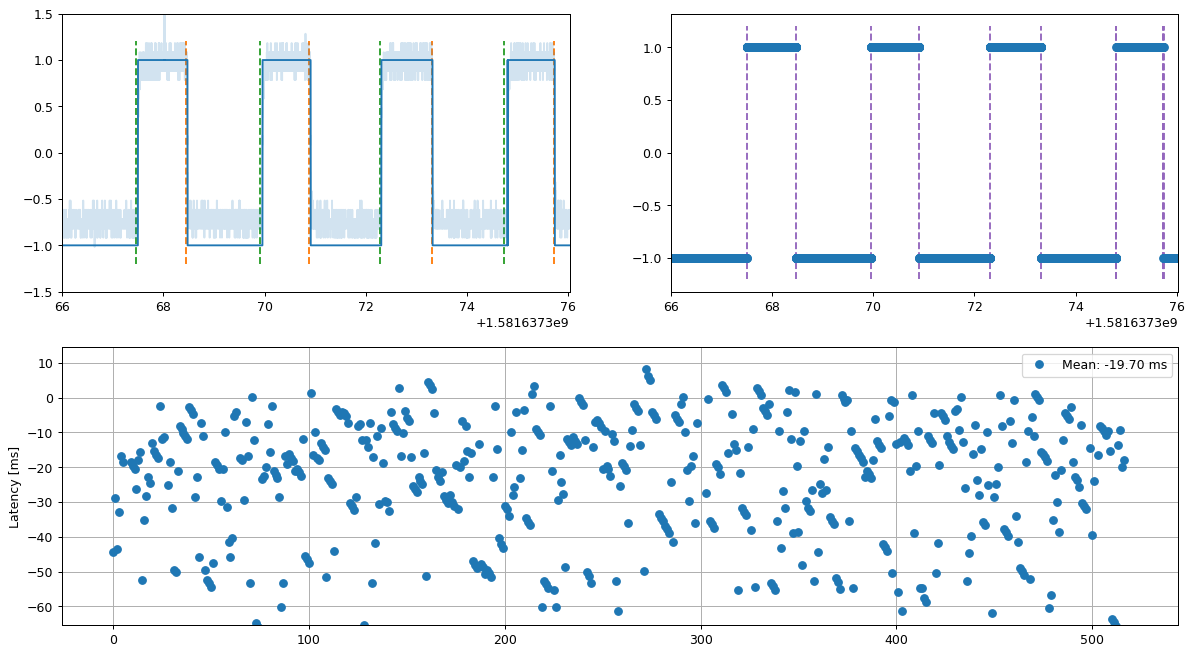

In [283]:
with HDF5_Reader(f'records/{file}') as reader:
    sample_rate = reader.header['sample_rate']
    markers = reader.markers
    aux_timestamp = reader.aux_timestamp[:]
    aux = reader.aux[:]
    eeg = reader.eeg[:]
    streaming_sample_rate = reader.header['streaming_sample_rate']
    
# high = np.array(markers['HIGH-PRE'])
# low = np.array(markers['LOW-PRE'])
high = np.array(markers['HIGH-POST'])
low = np.array(markers['LOW-POST'])

high = high[high < aux_timestamp[-1]]
low = low[low < aux_timestamp[-1]]

high = high[high > aux_timestamp[0]]
low = low[low > aux_timestamp[0]]



data = aux[1].copy()
data = data-data.mean()

data[data>50] = np.nan
data[data<-50] = np.nan

data[data>0] = 1
data[data<0] = -1


plt.figure(figsize=(16, 9), dpi=90)

#---------------------------------------------------------------------------------------------
    
# Raw
# plt.figure(figsize=(16, 9), dpi=60)
plt.subplot(221)
plt.plot(aux_timestamp, data, '-', color='C0', alpha=1)
plt.plot(aux_timestamp, (aux[1]-np.mean(aux[1]))*0.1, '-', color='C0', alpha=0.2)
plt.vlines(high, -1.2, 1.2, color='C1', linestyles='--', label='HIGH')
plt.vlines(low, -1.2, 1.2, color='C2', linestyles='--', label='LOW')
plt.xlim(aux_timestamp[0], aux_timestamp[10000])
plt.ylim(-1.5, 1.5)
# plt.legend()

#---------------------------------------------------------------------------------------------
plt.subplot(222)
# plt.figure(figsize=(30, 9), dpi=60)
plt.plot(aux_timestamp, data, 'o')
data_ = data.copy()
data_[data<0] = 0
peaks = np.abs(np.diff(data_, append=0))
peaks[peaks<1] = np.nan
# plt.plot(aux_timestamp, peaks, 'o', color='C2', alpha=0.2)
peaks = aux_timestamp[np.argwhere(peaks==1).T][0]
plt.vlines(peaks, -1.2, 1.2, color='C4', linestyles='--')
# plt.vlines(high, -1.2, 1.2, color='C1', linestyles='--', label='HIGH')
# plt.vlines(low, -1.2, 1.2, color='C2', linestyles='--', label='LOW')
plt.xlim(aux_timestamp[0], aux_timestamp[10000])

#---------------------------------------------------------------------------------------------
# Latency
plt.subplot(212)
# plt.figure(figsize=(30, 9), dpi=60)
# latency = np.array([np.min(np.abs([high[np.argmin(np.abs(high - peak))] - peak, low[np.argmin(np.abs(low - peak))] - peak])) for peak in peaks])
fix_peaks = [[high[np.argmin(np.abs(high - peak))] - peak, low[np.argmin(np.abs(low - peak))] - peak] for peak in peaks]
latency = np.array([j[np.argmin(np.abs(j))] for j in fix_peaks])*1000
plt.plot(latency, 'o', label=f'Mean: {np.median(latency):.2f} ms')
plt.ylabel('Latency [ms]')
plt.ylim(latency.mean()-latency.std(), latency.mean()+latency.std())
plt.legend()
plt.grid()